In [40]:
!unzip utkface-new.zip

unzip:  cannot find or open utkface-new.zip, utkface-new.zip.zip or utkface-new.zip.ZIP.


In [41]:
fldr="/kaggle/input/utkface-new/UTKFace"

In [42]:
import os
files=os.listdir(fldr)
print(int(files[0].split('_')[0]))
print(files[0])

26
26_0_2_20170104023102422.jpg.chip.jpg


In [43]:
import cv2
ages=[]
genders=[]
images=[]

for i, fle in enumerate(files):
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  total=fldr+'/'+fle
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(48,48))
  images.append(image)
#   if i % 1000 == 0:
#     print(i)

In [44]:
for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  ages.append(age)
  genders.append(gender)

In [45]:
#from google.colab.patches import cv2_imshow
#cv2_imshow(images[24])

In [46]:
print(ages[24])
print(genders[24])

38
0


In [47]:
# cv2_imshow(images[53])

In [48]:
print(ages[53])
print(genders[53])

75
0


In [49]:
import numpy as np
images_f=np.array(images)
genders_f=np.array(genders)
ages_f=np.array(ages)

In [50]:
np.save('image.npy',images_f)
np.save('gender.npy',genders_f)
np.save('age.npy',ages_f)

Male = 0
Female= 1

In [51]:
values, counts = np.unique(genders_f, return_counts=True)
print(counts)

[12391 11317]


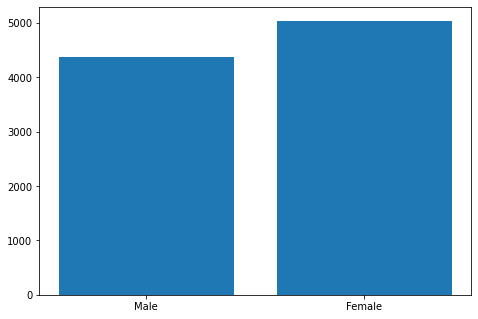

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
values=[4372,5047]
ax.bar(gender,values)
plt.show()

In [53]:
values, counts = np.unique(ages_f, return_counts=True)
print(counts)

[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


In [54]:
val=values.tolist()
cnt=counts.tolist()

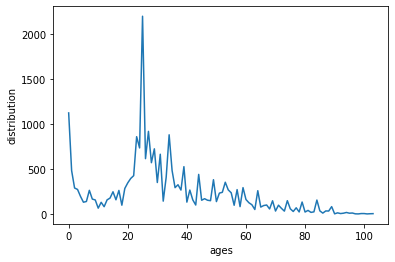

In [55]:
plt.plot(counts)
plt.xlabel('ages')
plt.ylabel('distribution')
plt.show()

In [56]:
labels=[]

i=0
while i<len(ages):
  label=[]
  label.append([ages[i]])
  label.append([genders[i]])
  labels.append(label)
  i+=1

In [57]:
images_f_2=images_f/255
labels_f=np.array(labels)
images_f_2.shape

(23708, 48, 48, 3)

In [58]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, Y_train, Y_test= train_test_split(images_f_2, labels_f,test_size=0.25)

In [60]:
Y_train[0:5]

array([[[31],
        [ 0]],

       [[ 7],
        [ 1]],

       [[83],
        [ 1]],

       [[52],
        [ 0]],

       [[45],
        [ 0]]])

In [61]:
Y_train_2=[Y_train[:,1],Y_train[:,0]]
Y_test_2=[Y_test[:,1],Y_test[:,0]]

In [62]:
Y_train_2[0][0:5]

array([[0],
       [1],
       [1],
       [0],
       [0]])

In [63]:
Y_train_2[1][0:5]

array([[31],
       [ 7],
       [83],
       [52],
       [45]])

In [64]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=32,kernel_size=(3, 3),padding = 'same',kernel_regularizer=l2(0.01))(input_tensor)
    x = Dropout(0.2)(x)
    x= Activation('relu')(x)

    return x
def model(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,64)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,32)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,64)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,512)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(1,activation="relu",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1,output_2])
  model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",
	metrics=["accuracy"])
  
  return model

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [66]:
fle_s='model_prediction.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_loss',restore_best_weights=True),
callback_list=[checkpointer,Early_stop]

In [67]:
# Instantiate the model
model_instance = model((48, 48, 3))  # Assuming your input shape is (48, 48, 3)

# Define the file path to save the model
fle_s = 'model_prediction.h5'

# Define callbacks
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_loss', restore_best_weights=True)
callback_list = [checkpointer, Early_stop]

# Train the model
History = model_instance.fit(X_train, Y_train_2, batch_size=64, validation_data=(X_test, Y_test_2), epochs=160, callbacks=callback_list)


Epoch 1/160
278/278 [==============================] - 10s 10ms/step - loss: 17.8751 - sex_out_loss: 0.7055 - age_out_loss: 16.6870 - sex_out_accuracy: 0.5702 - age_out_accuracy: 0.0471 - val_loss: 23.7465 - val_sex_out_loss: 0.6850 - val_age_out_loss: 22.6922 - val_sex_out_accuracy: 0.5173 - val_age_out_accuracy: 0.0476

Epoch 00001: val_loss improved from inf to 23.74651, saving model to model_prediction.h5
Epoch 2/160
278/278 [==============================] - 2s 8ms/step - loss: 15.7942 - sex_out_loss: 0.6305 - age_out_loss: 14.7847 - sex_out_accuracy: 0.6446 - age_out_accuracy: 0.0473 - val_loss: 19.6326 - val_sex_out_loss: 0.6232 - val_age_out_loss: 18.6061 - val_sex_out_accuracy: 0.6884 - val_age_out_accuracy: 0.0476

Epoch 00002: val_loss improved from 23.74651 to 19.63264, saving model to model_prediction.h5
Epoch 3/160
278/278 [==============================] - 2s 7ms/step - loss: 14.2381 - sex_out_loss: 0.5807 - age_out_loss: 13.2239 - sex_out_accuracy: 0.6948 - age_out_accu

In [68]:
from tensorflow.keras.models import load_model
Model = load_model('/kaggle/input/age-and-sex-prediction-by-artificial-intelligence/model_prediction_1.h5')

In [69]:
Model.evaluate(X_test,Y_test_2)

186/186 [==============================] - 1s 3ms/step - loss: 5.8169 - sex_out_loss: 0.2237 - age_out_loss: 4.8068 - sex_out_accuracy: 0.8986 - age_out_accuracy: 0.0476


[5.816921710968018,
 0.22370345890522003,
 4.8068156242370605,
 0.8985996246337891,
 0.047578874975442886]

In [70]:
pred=Model.predict(X_test)

In [71]:
pred[1]

array([[24.977432 ],
       [23.522335 ],
       [ 1.4997629],
       ...,
       [26.228027 ],
       [48.44256  ],
       [31.385918 ]], dtype=float32)

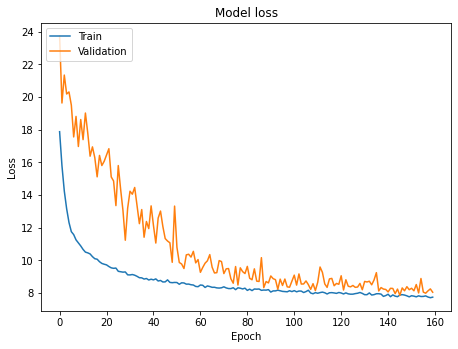

In [72]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

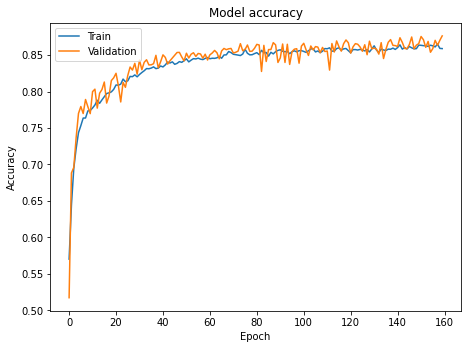

In [73]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

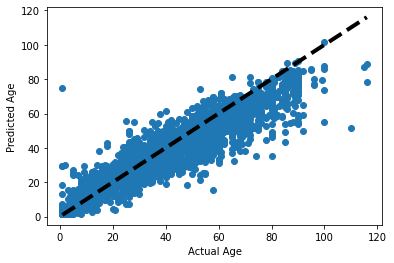

In [74]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [75]:
i=0
Pred_l=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1


In [76]:
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import classification_report 

In [77]:

report=classification_report(Y_test_2[0], Pred_l)

In [78]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3065
           1       0.95      0.84      0.89      2862

    accuracy                           0.90      5927
   macro avg       0.90      0.90      0.90      5927
weighted avg       0.90      0.90      0.90      5927



In [79]:

results = confusion_matrix(Y_test_2[0], Pred_l)

<AxesSubplot:>

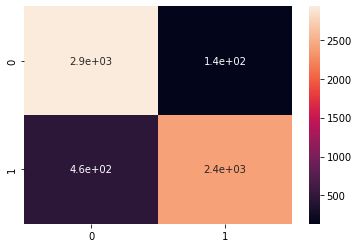

In [80]:
import seaborn as sns

sns.heatmap(results, annot=True)

Predicted Age: 21
Predicted Sex: Female


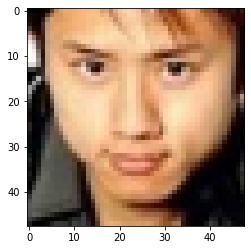

In [81]:
def test_image(ind, images_f, images_f_2, Model):
    plt.imshow(images_f[ind])
    image_test = images_f_2[ind]
    pred_1 = Model.predict(np.array([image_test]))
    sex_f = ['Male', 'Female']
    age = int(np.round(pred_1[1][0]))
    sex = int(np.round(pred_1[0][0]))
    print("Predicted Age: " + str(age))
    print("Predicted Sex: " + sex_f[sex])
    return pred_1  # Return the predictions

# Example usage
pred_1 = test_image(0, images_f, images_f_2, model_instance)  # Assuming you want to test the first image

# Now you can use pred_1 outside the function
age_adjusted = int(np.round(pred_1[1][0])) - 1310
sex = int(np.round(pred_1[0][0]))


Predicted Age: 21
Predicted Sex: Female


[array([[0.90694946]], dtype=float32), array([[20.52318]], dtype=float32)]

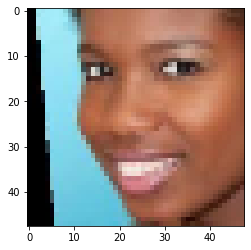

In [103]:
test_image(57,images_f,images_f_2,Model)

Predicted Age: 44
Predicted Sex: Male


[array([[0.01951399]], dtype=float32), array([[43.982647]], dtype=float32)]

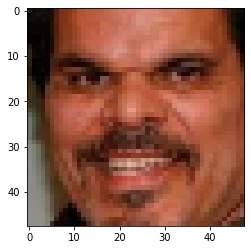

In [104]:
test_image(137,images_f,images_f_2,Model)

Predicted Age: 38
Predicted Sex: Male


[array([[0.0158926]], dtype=float32), array([[37.93207]], dtype=float32)]

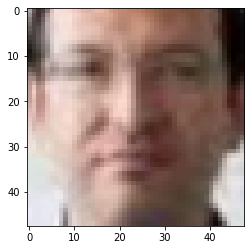

In [105]:
test_image(502,images_f,images_f_2,Model)

Predicted Age: 31
Predicted Sex: Male


[array([[0.1720728]], dtype=float32), array([[31.40316]], dtype=float32)]

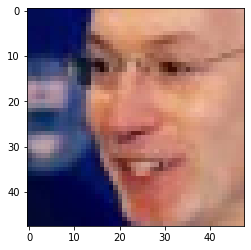

In [106]:
test_image(24,images_f,images_f_2,Model)